In [1]:
import json
import pytorch_lightning as pl
from einops import rearrange
import torch
import torchaudio
from torch.utils.data import DataLoader
import safetensors
from safetensors.torch import load_file
import random

import shutil
from collections import OrderedDict
from datetime import datetime
import os
import torch.nn.functional as F

from stable_audio_tools import create_model_from_config, replace_audio, save_audio
from stable_audio_tools.data.dataset import VideoFeatDataset, VideoFeatDataset_VL, collation_fn
from stable_audio_tools.training.training_wrapper import DiffusionCondTrainingWrapper
from stable_audio_tools.inference.generation import generate_diffusion_cond, generate_diffusion_cond_from_path


model_config_file = './stable_audio_tools/configs/model_config_gc16000.json'
model_config_file = './stable_audio_tools/configs/model_config_vl30.json'
# model_config_file = './stable_audio_tools/configs/model_config_ss30.json'


with open(model_config_file) as f:
    model_config = json.load(f)
    sample_rate = model_config["sample_rate"]
    sample_size = model_config["sample_size"]
    fps = model_config["fps"]
    variable_length = model_config["variable_length"]
    force_channels = "stereo" if model_config["audio_channels"] == 2 else "mono"


model = create_model_from_config(model_config)
sample_size, sample_rate, sample_size/sample_rate, variable_length, fps, force_channels

/home/chengxin/chengxin/anaconda3/envs/stableaudio/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1323000, 44100, 30.0, 30, 8, 'stereo')

In [2]:
import safetensors.torch


model_dir = './weight/StableAudio/2024-08-04 02:52:24'
model_name = 'epoch=60-step=2818'  
# ./weight/StableAudio/lightning_logs/version_3/checkpoints  epoch=9-step=14620                                     FPS=22  config
# ./weight/StableAudio/2024-07-06 10:28:13               在basemodel的基础上 加入pos_emb,利用AS进行训练<epoch=30-step=58>   time_align和生成效果表现较好(best)   FPS=22 config
# ./weight/StableAudio/2024-07-20 13:34:51               在basemodel的基础上 加入pos_emb 利用VGG重新训练 epoch=3-step=1817                          FPS=22  config
# ./weight/StableAudio/2024-07-22 19:08:45               在不load t2a-crosscond&conditioner的基础上 加入rotary_cond_emb 利用AS重新训练              FPS=8 sr=16000  config_rotebd
# ./weight/StableAudio/2024-07-24 23:06:33               在bestmodel的基础上    利用AS继续进行训练     <epoch=70-step=304> <epoch=150-step=304>     FPS=22  config
# ./weight/StableAudio/2024-08-01 09:36:20               在lastmodel<epoch=70-step=304>的基础上    利用ASVGG继续进行训练   <epoch=45-step=2818>  <epoch=29-step=2818>    FPS=22  config
# ./weight/StableAudio/2024-08-04 02:52:24               在lastmodel<epoch=29-step=2818>的基础上    利用ASVGG继续进行训练  <epoch=27-step=2818> <epoch=36-step=2818> <epoch=60-step=2818>
# ./weight/StableAudio/2024-08-15 11:31:46               在lastmodel<epoch=36-step=2818>的基础上 加入global_cond_ids ["seconds_start", "seconds_total"] samplesize44100*30 variablelength30
# ./weight/StableAudio/2024-08-19 11:11:56               在lastmodel<epoch=36-step=2818>, sr16000 ss160000 fps8 noclamp  加入global_cond_ids 利用VGG继续进行训练   <epoch=60-step=2818> <epoch=30-step=2818> <epoch=35-step=2818> 

try:
    state_dict = load_file(f'{model_dir}/{model_name}.safetensors')
except:
    state_dict = torch.load(f'{model_dir}/{model_name}.ckpt')['state_dict']
    state_dict = OrderedDict([(".".join(key.split('.')[1:]), value)  for key, value in state_dict.items()])
    safetensors.torch.save_file(state_dict, f'{model_dir}/{model_name}.safetensors')

print(f'{model_dir}/{model_name}.safetensors')

# cond_state_dict = load_file(f'./weight/StableAudio/model.safetensors')
# cond_state_dict = {k: v for k, v in cond_state_dict.items() if ('seconds' in k)}
# state_dict.update(cond_state_dict)
model.load_state_dict(state_dict, strict=True)

./weight/StableAudio/2024-08-04 02:52:24/epoch=60-step=2818.safetensors


<All keys matched successfully>

In [3]:
from moviepy.editor import VideoFileClip

device = 0
conditioning = {
    # 'seconds_start': [0],
    # 'seconds_total': [10],
    'feature': ['/home/chengxin/chengxin/VGGSound/dataset/test/10/__2MwJ2uHu0_000004.mp4']
}
video_clip = VideoFileClip(conditioning['feature'][0])
seconds_total = int(video_clip.duration)
seconds_total = 10

output = generate_diffusion_cond(
    model = model.to(device),
    steps=150,
    cfg_scale=7,
    conditioning=conditioning,
    sample_size=int(sample_rate*seconds_total),
    batch_size=len(conditioning['feature']),
    sigma_min=0.3,
    sigma_max=500,
    sampler_type="dpmpp-3m-sde",
    device=device
)

audio_path = "./test.wav"
waveform = output[0:1,...,:int(seconds_total*sample_rate)]
# print(output.shape, output[idx:idx+1].shape, waveform.shape)
save_audio(waveform, audio_path, sample_rate)

2699835069
Extracting features from video:/home/chengxin/chengxin/VGGSound/dataset/test/10/__2MwJ2uHu0_000004.mp4


  4%|▍         | 6/150 [00:00<00:07, 19.73it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 11%|█▏        | 17/150 [00:00<00:03, 37.13it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 19%|█▉        | 29/150 [00:00<00:02, 45.64it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 27%|██▋       | 40/150 [00:01<00:02, 47.56it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 31%|███       | 46/150 [00:01<00:02, 48.64it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 38%|███▊      | 57/150 [00:01<00:01, 47.95it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 45%|████▌     | 68/150 [00:01<00:01, 48.90it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 53%|█████▎    | 79/150 [00:01<00:01, 45.03it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 56%|█████▌    | 84/150 [00:02<00:01, 39.14it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 63%|██████▎   | 94/150 [00:02<00:01, 38.49it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 67%|██████▋   | 100/150 [00:02<00:01, 42.16it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 75%|███████▍  | 112/150 [00:02<00:00, 47.52it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 82%|████████▏ | 123/150 [00:02<00:00, 48.82it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 89%|████████▉ | 134/150 [00:03<00:00, 49.89it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


 97%|█████████▋| 146/150 [00:03<00:00, 50.67it/s]

torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])
torch.Size([2, 220, 768])


100%|██████████| 150/150 [00:03<00:00, 44.10it/s]


torch.Size([2, 220, 768])


In [3]:
import torch
import torch.nn.functional as F
from torch import nn, einsum
from torch.cuda.amp import autocast

class RotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim,
        use_xpos = False,
        scale_base = 512,
        interpolation_factor = 1.,
        base = 10000,
        base_rescale_factor = 1.
    ):
        super().__init__()
        # proposed by reddit user bloc97, to rescale rotary embeddings to longer sequence length without fine-tuning
        # has some connection to NTK literature
        # https://www.reddit.com/r/LocalLLaMA/comments/14lz7j5/ntkaware_scaled_rope_allows_llama_models_to_have/
        base *= base_rescale_factor ** (dim / (dim - 2))

        inv_freq = 1. / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

        assert interpolation_factor >= 1.
        self.interpolation_factor = interpolation_factor

        if not use_xpos:
            self.register_buffer('scale', None)
            return

        scale = (torch.arange(0, dim, 2) + 0.4 * dim) / (1.4 * dim)

        self.scale_base = scale_base
        self.register_buffer('scale', scale)

    def forward_from_seq_len(self, seq_len):
        device = self.inv_freq.device

        t = torch.arange(seq_len, device = device)
        return self.forward(t)

    @autocast(enabled = False)
    def forward(self, t):
        device = self.inv_freq.device

        t = t.to(torch.float32)

        t = t / self.interpolation_factor

        freqs = torch.einsum('i , j -> i j', t, self.inv_freq)
        freqs = torch.cat((freqs, freqs), dim = -1)

        if self.scale is None:
            return freqs, 1.

        power = (torch.arange(seq_len, device = device) - (seq_len // 2)) / self.scale_base
        scale = self.scale ** rearrange(power, 'n -> n 1')
        scale = torch.cat((scale, scale), dim = -1)

        return freqs, scale

In [4]:
x = torch.zeros([20, 220, 1536]).to('cuda')
context = torch.zeros([20, 220, 768]).to('cuda')
rotary_pos_emb_layer = RotaryEmbedding(32)
rotary_pos_emb = rotary_pos_emb_layer.forward_from_seq_len(120)  # (Tensor([seq_len, 32], 1)


model.to('cuda')
x += model.model.model.transformer.pos_emb(x)
context += model.model.model.transformer.pos_emb_cond(x)


In [10]:
transformer_block = model.model.model.transformer.layers[0]
out, softmax_lse, S_dmask = transformer_block.cross_attn(x = transformer_block.cross_attend_norm(x), context=context, rotary_pos_emb=rotary_pos_emb)
softmax_lse.shape

torch.Size([20, 24, 220])

In [62]:
q1 = q1.reshape([20, 220, 12*64]).permute(0, 2, 1)
q2 = q2.reshape([20, 220, 12*64]).permute(0, 2, 1)
k = k.reshape([20, 220, 12*64])


result = torch.bmm(k, q2)
q1.shape, k.shape, result.shape


(torch.Size([20, 768, 220]),
 torch.Size([20, 220, 768]),
 torch.Size([20, 220, 220]))

In [63]:
result[1][:20, :20].shape

torch.Size([20, 20])

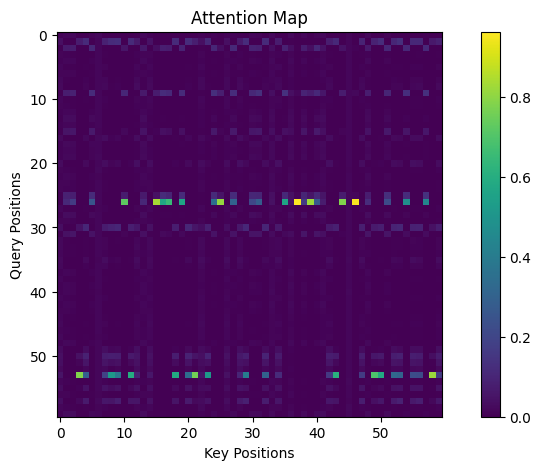

In [69]:

import matplotlib.pyplot as plt
import numpy as np

attention_weights = result[1][90:150, 90:150]
attention_weights = attention_weights.softmax(dim = 0).cpu().detach().numpy()

# 绘制注意力图
plt.figure(figsize=(10, 5))
plt.imshow(attention_weights, cmap='viridis')
plt.colorbar()
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.title('Attention Map')
plt.show()

In [2]:
rotary_pos_emb_layer = RotaryEmbedding(32)
rotary_pos_emb = rotary_pos_emb_layer.forward_from_seq_len(120)  # (Tensor([seq_len, 32], 1)

freqs, _ = rotary_pos_emb

# q_dtype = q.dtype
# k_dtype = k.dtype

# q = q.to(torch.float32)
# k = k.to(torch.float32)
# freqs = freqs.to(torch.float32)

# q = apply_rotary_pos_emb(q, freqs)
# k = apply_rotary_pos_emb(k, freqs)

# q = q.to(q_dtype)
# k = k.to(k_dtype)